In [6]:
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics

def mergeModDFs(mod_df1, mod_df2):
    on_list = ["chromosome", "chromStart", "chromEnd", "modification_type"]
    redundant_cols = ["method", "readCount"]

    if mod_df1["method"].str.contains("Nanopore").all() == True:
        suffixes = ["_Nano", "_BS" ]
    else:
        suffixes = ["_BS", "_Nano"]

    merged = pd.merge(mod_df1.drop(columns=redundant_cols), 
                      mod_df2.drop(columns=redundant_cols), 
                      "inner", on_list, suffixes=suffixes).reset_index(drop=True)
    
    return merged

def binBenchmark(merged_df):
    merged_df["BS_bin"] = pd.cut(merged_df["percentMeth_BS"], 20)
    return merged_df

def makeLineplot(merged_df_wBSbin):
    return pd.DataFrame(merged_df_wBSbin.groupby("BS_bin").median(numeric_only=True)["percentMeth_Nano"])

def linePlotWrapper(merged_df):
    filtered_and_merged_wBSbin_df = binBenchmark(merged_df)
    return makeLineplot(filtered_and_merged_wBSbin_df)

In [7]:
from ProjectTools import OpenBeds
import math

dry = True

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount

    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    dud_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    del dud_df

    nano_hmc_df = filterDepth(nano_hmc_df)
    nano_mc_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_bed_path))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    dud_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    del dud_df

    nano_hmc_df = filterDepth(nano_hmc_df)
    nano_mc_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_bed_path))

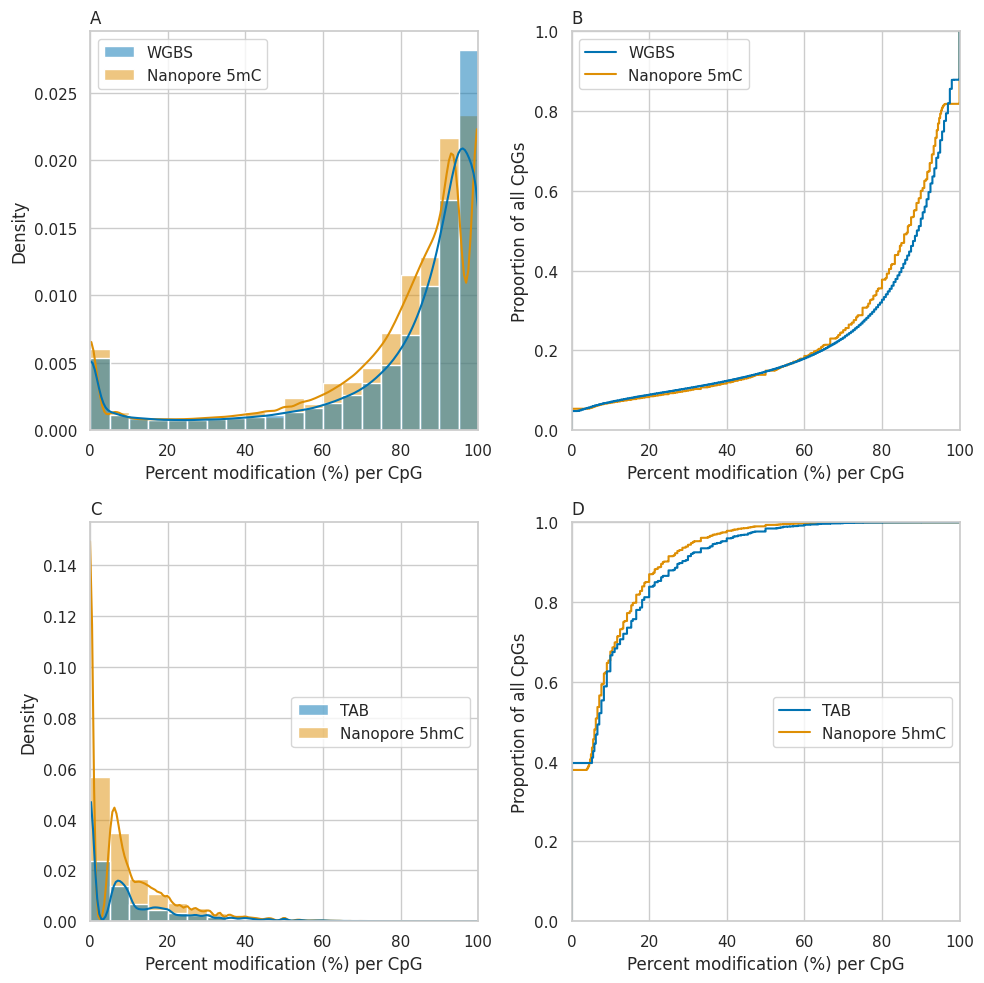

In [8]:
import seaborn as sns
import matplotlib.pyplot as pl

sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = pl.figure(figsize=(10, 10)) 
gs = fig2.add_gridspec(nrows=2, ncols=2)

ax1 = fig2.add_subplot(gs[0, 0])
ax2 = fig2.add_subplot(gs[0, 1])
ax3 = fig2.add_subplot(gs[1, 0])
ax4 = fig2.add_subplot(gs[1, 1])

ecdf_df = pd.concat([wgbs_df, nano_mc_df, tab_df, nano_hmc_df], ignore_index=True)

sns.kdeplot(ecdf_df.loc[ecdf_df["modification_type"] == "5mC"], x="percentMeth", hue="method", ax=ax1, fill=False)
sns.histplot(ecdf_df.loc[ecdf_df["modification_type"] == "5mC"], x="percentMeth", hue="method", stat="density", binrange=(0, 100), bins=20, multiple="layer", ax=ax1)
sns.move_legend(ax1, "upper left", title=None)
ax1.set_xlabel("Percent modification (%) per CpG")
ax1.set_xlim([0, 100])
ax1.set_title("A", loc="left")

sns.ecdfplot(ecdf_df.loc[ecdf_df["modification_type"] == "5mC"], x="percentMeth", hue="method", ax=ax2)
sns.move_legend(ax2, "upper left", title=None)
ax2.set_ylabel("Proportion of all CpGs")
ax2.set_xlabel("Percent modification (%) per CpG")
# ax1.set_xticks(np.arange(0, 120, 20), labels=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]) # to make proportions instead of percentages 
ax2.set_title("B", loc="left")
ax2.set_xlim([0, 100])

sns.kdeplot(ecdf_df.loc[ecdf_df["modification_type"] == "5hmC"], x="percentMeth", hue="method", common_norm=True, ax=ax3)
sns.histplot(ecdf_df.loc[ecdf_df["modification_type"] == "5hmC"], x="percentMeth", hue="method", stat="density", common_norm=True, binrange=(0, 100), bins=20, multiple="layer", ax=ax3)
sns.move_legend(ax3, "center right", title=None)
ax3.set_title("C", loc="left")
ax3.set_xlabel("Percent modification (%) per CpG")
ax3.set_xlim([0, 100])

sns.ecdfplot(ecdf_df.loc[ecdf_df["modification_type"] == "5hmC"], x="percentMeth", hue="method", ax=ax4)
sns.move_legend(ax4, "center right", title=None)
ax4.set_ylabel("Proportion of all CpGs")
ax4.set_xlabel("Percent modification (%) per CpG")
ax4.set_xlim([0, 100])
ax4.set_title("D", loc="left")

fig2.tight_layout()

In [ ]:
from scipy import stats
from scipy import optimize

beta_dist = stats.beta.rvs(2, 2, size=5000)

import distfit

dist = distfit.distfit()
dist.fit_transform(beta_dist)

In [ ]:
mc_benchmark = ecdf_df.loc[ecdf_df["method"] == "WGBS", ["percentMeth"]].to_numpy()
dist.fit_transform(mc_benchmark)